# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

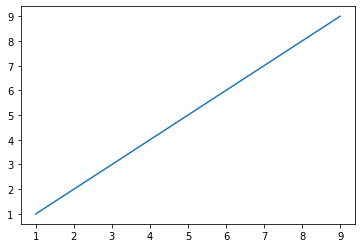

In [2]:
plt.plot(range(1,10),range(1,10))
plt.show()